In [1]:
import glob
import math
import numpy as np
import os
import pandas as pd
import re
import shutil
import sys
from tqdm import tqdm

#####################################################
# functions for loading data of specific patient
#####################################################
def load_patient_index(path):
    df_ind = pd.read_csv(path)
    return { pid : part for (pid, part) in zip(df_ind['patientid'], df_ind['part'])}

def load_patient(pid, data_path, pat_index):
    df_part = pd.read_parquet(os.path.join(data_path, 'observation_tables', 'parquet', f"part-{pat_index[pid]}.parquet"))
    
    return df_part.query(f'patientid == {pid}')

def load_patient_data(data_path, pid):
    pat_index = load_patient_index(os.path.join(data_path, 'observation_tables', 'observation_tables_index.csv'))
    return load_patient(pid, data_path, pat_index)  

In [2]:
data_raw_path = '../physionet.org/files/hirid/1.1.1/raw_stage/observation_tables_parquet'   
data_merged_path = '../physionet.org/files/hirid/1.1.1/merged_stage/merged_stage_parquet'
data_imputed_path = '../physionet.org/files/hirid/1.1.1/imputed_stage/imputed_stage_parquet'

patient_info_file = '../physionet.org/files/hirid/1.1.1/reference_data/general_table.csv'
variable_file = '../physionet.org/files/hirid/1.1.1/reference_data/hirid_variable_reference.csv'
variable_preprocessed_file = '../physionet.org/files/hirid/1.1.1/reference_data/hirid_variable_reference_preprocessed.csv'

patient_info = pd.read_csv(patient_info_file)
patient_info['admissiontime'] = pd.to_datetime(patient_info['admissiontime'])
patient_info['los'] = -1
variable_table = pd.read_csv(variable_file)
variable_preprocessed_table = pd.read_csv(variable_preprocessed_file)

selected_med_file = '../HiRID_selected_variables-input_dict.csv'
selected_physio_file = '../HiRID_selected_variables-output_dict.csv'
selected_med = pd.read_csv(selected_med_file)
selected_physio = pd.read_csv(selected_physio_file)

In [3]:
pharma_path = '../physionet.org/files/hirid/1.1.1/raw_stage/pharma_records_parquet'
pharma_data = pd.read_parquet(os.path.join(pharma_path, 'pharma_records', 'parquet'))

# data statistics

In [4]:
index_obs_ = '../physionet.org/files/hirid/1.1.1/raw_stage/observation_tables_parquet/observation_tables/observation_tables_index.csv'
index_phm_ = '../physionet.org/files/hirid/1.1.1/raw_stage/pharma_records_parquet/pharma_records/pharma_records_index.csv'

index_obs = load_patient_index(index_obs_)
index_phm = load_patient_index(index_phm_)

pid_with_pharma = [k for k in index_obs if k in index_phm]

#patient without pharma record:
pid_no_pharma = [k for k in index_obs if k not in index_phm]
print(len(pid_with_pharma), len(pid_no_pharma))
#patient with no pharma and no observation record: 26045

pid_valid = pharma_data.loc[pharma_data['pharmaid'].isin(selected_med['variable_id']), 'patientid'].unique()
print(len(pid_valid))

33815 89
30868


In [5]:
# result from data_statistics.py file
import pickle

stat_med = pickle.load(open('stat_med.p', 'rb'))
stat_physio = pickle.load(open('stat_physio.p', 'rb'))

# Plots

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [21]:
print("Male patient - discharged alive: ", patient_info.loc[(patient_info['sex']=='M') & (patient_info['discharge_status']=='alive')].shape[0])
print("Male patient - discharged dead: ", patient_info.loc[(patient_info['sex']=='M') & (patient_info['discharge_status']=='dead')].shape[0])

print("Female patient - discharged alive: ", patient_info.loc[(patient_info['sex']=='F') & (patient_info['discharge_status']=='alive')].shape[0])
print("Female patient - discharged dead: ",patient_info.loc[(patient_info['sex']=='F') & (patient_info['discharge_status']=='dead')].shape[0])

Male patient - discharged alive:  20324
Male patient - discharged dead:  1281
Female patient - discharged alive:  11280
Female patient - discharged dead:  781


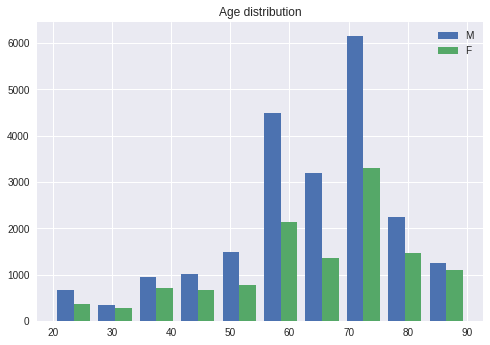

In [22]:
plt.hist([patient_info.loc[patient_info['sex']=='M', 'age'], 
          patient_info.loc[patient_info['sex']=='F', 'age']], label=['M', 'F'])
plt.title('Age distribution')
plt.legend();

In [75]:
patient_info_subset = pickle.load(open('patient_info_50.p', 'rb'))
patient_info_subset = patient_info_subset[patient_info_subset['los']!=-1]
patient_info_subset

,patientid,admissiontime,sex,age,discharge_status,los
0,1,2197-04-03 19:15:00,M,75,alive,0 days 15:31:00
1,2,2117-10-18 22:35:00,M,80,alive,8 days 08:40:00
2,3,2163-10-17 19:15:00,M,55,alive,0 days 18:07:00
3,4,2149-01-08 15:30:00,M,75,alive,3 days 21:58:00
4,5,2144-06-06 16:15:00,M,20,alive,2 days 21:20:00
...,...,...,...,...,...,...
10023,10024,2191-05-20 15:30:00,F,75,alive,1 days 22:24:00
10024,10025,2193-09-05 23:45:00,M,45,alive,0 days 13:39:04.420000
10025,10026,2173-11-05 13:39:00,M,55,alive,1 days 00:22:17.300000
10026,10027,2164-11-27 17:00:00,F,60,alive,1 days 18:15:00


In [87]:
id = 1

los[id], los[id].seconds, los[id].days

(Timedelta('8 days 08:40:00'), 31200, 8)

In [101]:
los_timedelta = patient_info_subset.loc[patient_info_subset['los']!=-1, 'los'].values
los = [l.days*24 + l.seconds/3600 for l in los_timedelta]

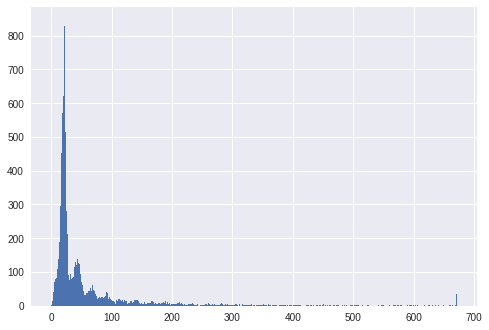

In [109]:
plt.hist(los, bins=500);

In [79]:
patient_data.loc[patient_data['variableid'].isin([9990002, 9990004]), 'value'].unique().item()

110.0

In [24]:
count_med = {vid: 0 for vid in selected_med['variable_id'].unique()}

for pid in tqdm(pid_valid):
    for vid in stat_med[pid]:
        if stat_med[pid][vid]!=0:
            count_med[vid] += 1

100%|█████████████████████████████████| 30868/30868 [00:00<00:00, 35679.53it/s]


In [28]:
count_med_sorted = {k: v for k, v in sorted(count_med.items(), key=lambda item: item[1], reverse=True)}

In [38]:
from IPython.display import display, HTML

In [54]:
pharma_name = [selected_med.loc[selected_med['variable_id']==vid, 'variable_name'].item() for vid in count_med_sorted]
df_med_count = pd.DataFrame.from_dict(count_med_sorted, orient='index', columns=['count'])
df_med_count['pharma'] = pharma_name
df_med_count = df_med_count.reset_index().rename(columns={'index':'pharmaid'})

display(HTML(df_med_count.to_html()))

,pharmaid,count,pharma
0,208,17702,Disoprivan 2%
1,1000421,16116,Magnesium Sulfat 50% 10 ml
2,1000699,12668,Disoprivan 2% BOLUS
3,1000657,9221,Noradrenalin 20 µg/ml Perfusor
4,1000747,8755,Lasix Bolus 20mg Amp.
5,251,7841,Dormicum inj 1 mg/ml
6,1000100,7810,Intravenous blood transfusion of packed cells
7,15,6664,Insulin Actrapid inj 100 U/ml
8,1000396,6541,Kalium Chlorid 15% 10 ml
9,1000763,6283,Ebrantil Inj Lsg


In [64]:
# Fluid
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Fluid', 'variable_id'])]

,pharmaid,count,pharma
146,30005075,0,Infusion of saline solution
147,30005080,0,Intravenous fluid colloid administration


In [66]:
# Blood components
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Blood components', 'variable_id'])]

,pharmaid,count,pharma
6,1000100,7810,Intravenous blood transfusion of packed cells
19,1000050,2492,Transfusion of plasma (FFP)
27,1000743,1967,Intravenous blood transfusion of packed cells
29,1000201,1877,Platelet transfusion
148,1000744,0,Transfusion of plasma (FFP)
149,1000245,0,Platelet transfusion


In [65]:
# Catecholamines + postivie inotrop
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Catecholamines + postivie inotrop', 'variable_id'])]

,pharmaid,count,pharma
3,1000657,9221,Noradrenalin 20 µg/ml Perfusor
13,1000658,4753,Noradrenalin 10 µg/ml Bolus
14,426,4427,Dobutrex 250 mg/20ml
21,1000649,2335,Adrenalin 20 µg/ml Perfusor
23,1000656,2255,Noradrenalin 100 µg/ml Perfusor
32,1000655,1511,Adrenalin 10 µg/ml Bolus
43,1000650,1019,Adrenalin 100 µg/ml Perfusor
54,11,664,Atropine Sulfat Sintetica inj 0.5 mg/ml
72,71,256,Adrenalin 1mg/ml
91,1000750,87,Adrenalin 100 µg/ml Bolus


In [63]:
# Vasodilatators
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Vasodilatators', 'variable_id'])]

,pharmaid,count,pharma
35,1000867,1305,Nitriate 0.5mg/ml
42,1000459,1066,Nitroderm TTS 10
48,1000695,770,Nipruss 1mg/ml
52,1001047,688,Nitroprussiat Fides 0.5mg/ml
61,1000458,475,Nitroderm TTS 5
81,1000868,165,Nitriate 1mg/ml
88,1001048,92,Nitroprussiat Fides 1mg/ml
120,1001141,16,Nitroprusside DBL 0.5 mg/ml
131,117,10,Nitroglycerin Kps 0.8mg
142,1000795,4,Isoket Dosieraerosol


In [67]:
# Antihypertensiva
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Antihypertensiva', 'variable_id'])]

,pharmaid,count,pharma
9,1000763,6283,Ebrantil Inj Lsg
11,1000440,5602,Beloc ZOK ret Tbl 25 mg
18,386,2683,Trandate inj
33,1000439,1386,Beloc ZOK ret Tbl 50 mg
34,1000436,1374,Beloc Inj Lsg
38,1000270,1170,Norvasc Tabl 10 mg
39,85,1169,Nepresol inj 12.5 mg/ml
41,1000524,1085,Dyrenium comp. Kps
44,1000506,978,Aldactone Filmtbl 25 mg
45,1000271,963,Norvasc Tabl 5 mg


In [68]:
# Antiarrhythmika
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Antiarrhythmika', 'variable_id'])]

,pharmaid,count,pharma
22,431,2269,Cordarone inj 50 mg/ml
49,1000268,738,Cordarone Tbl 200 mg
57,1000821,553,Cordarone Perfusor
69,1,339,Digoxin inj 0.25 mg/ml
75,348,237,Digoxin Tabl 0.25 mg
92,1000901,79,Digoxin Tabl 0.125 mg


In [69]:
# Diuretika
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Diuretika', 'variable_id'])]

,pharmaid,count,pharma
4,1000747,8755,Lasix Bolus 20mg Amp.
31,1000521,1873,Torem Tbl 10 mg
46,482,818,Lasix Perfusor 250 mg Amp.
50,1000522,703,Torem Tbl 5 mg
55,1000428,652,Metolazon Tbl 5 mg
77,4,197,Lasix 40 mg tabl
95,1000254,70,Diamox Tbl 250 mg
108,438,39,Diamox inj 500 mg/5ml
110,1000520,36,Torem Inj Lsg 10 mg/2 ml
130,1000986,11,Torem Tbl 200 mg


In [70]:
# Hämofiltration
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Hämofiltration', 'variable_id'])]

,pharmaid,count,pharma
152,10002508,0,Haemofiltration/CRRT


In [71]:
# Sedation
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Sedation', 'variable_id'])]

,pharmaid,count,pharma
0,208,17702,Disoprivan 2%
2,1000699,12668,Disoprivan 2% BOLUS
5,251,7841,Dormicum inj 1 mg/ml
15,1000491,3627,Disoprivan 1%
40,252,1101,Dormicum Perfusor 5 mg/ml
47,1000607,791,Pentothal inj 0.5g
66,1000847,349,Dexdor Inf. Lsg
71,1000700,260,Dormicum 5mg/ml BOLUS
96,1001050,65,Disoprivan 2%
98,202,62,Pentothal 1g Inf Lsg


In [72]:
# Glucose level
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Glucose level', 'variable_id'])]

,pharmaid,count,pharma
7,15,6664,Insulin Actrapid inj 100 U/ml
10,1000724,5986,Insulin NovoRapid
36,1000544,1277,Glucose 20% /100ml
63,1000022,434,Glucose 10%
67,1000746,347,Glucose 20%/100ml Pflege
70,1000689,297,Glucose 20%
87,1000835,99,Glucose 20% /500ml
90,1000963,89,Insulin Lantus
97,1000690,64,Glucose 10%
100,1000381,59,Insulin Insulatard HM


In [73]:
# Electrolytes
df_med_count[df_med_count['pharmaid'].isin(selected_med.loc[selected_med['category']=='Electrolytes', 'variable_id'])]

,pharmaid,count,pharma
1,1000421,16116,Magnesium Sulfat 50% 10 ml
8,1000396,6541,Kalium Chlorid 15% 10 ml
12,1000612,4928,Kalium-Chlorid Sirup
16,1000080,3421,K-Cl conc
17,1000420,3291,Magnesiocard 5 mmol sachet
20,1000394,2359,Phoscap Phosphat-Kps
24,1000395,2135,Kalium Phosphat
25,1000398,2037,KCL Retard Zyma Drag
26,1000836,1982,Kalium Phosphat für Perfusor
28,1000292,1966,Calcium Sandoz Lsg 10% 10 ml
